---
author: "Ricardo Semião e Castro"
warning: false
message: false
format:
  pdf:
    toc: true
    toc-depth: 3
    number-sections: false
    include-in-header:
      text: |
        \usepackage{sectsty}
        \usepackage{etoolbox}
        \patchcmd{\tableofcontents}{\thispagestyle{plain}}{\thispagestyle{plain}\clearpage}{}{}
        \subsectionfont{\clearpage}
---

# Problem Set 4

## Setup

The files from this problem set can be found in [github.com/ricardo-semiao/task-masters -> quant-macro](https://github.com/ricardo-semiao/task-masters/tree/main/quant-macro).

Importing required libraries:

In [194]:
import numpy as np
import polars as pl

from time import time
from quantecon.markov import approximation as quant
from scipy.interpolate import interp1d

import plotnine as gg
from plotnine import ggplot, aes
from matplotlib.pyplot import show
from seaborn import heatmap

gg.theme_set(gg.theme_bw())
np.random.seed(12850281)

Now, I define some functions`, mostly to present results.

And a function to plot the policy results:

In [195]:
def plot_policy(x, title_add):
    x_dict = {f'z = {z_grid[j]:.2f}': x[:, j] for j in range(n_grid_z)}

    gdf_a = pl.DataFrame(x_dict)\
        .with_columns(x = a_grid)\
        .unpivot(
            index = 'x', on = x_dict.keys(),
            variable_name = 'Shock', value_name = 'Value'
        )\
        .with_columns(pl.col('Shock').cast(pl.Categorical))

    return (
        ggplot(gdf_a, aes('x', 'Value', color = 'Shock'))
        + gg.geom_line()
        + gg.labs(title = f"Policy Function of {title_add}")
    )

## Question 1.

In this question, we will deal with a variation on the Aiyagari model. In opposition to the complete model, we do not have disutility from labor (similar to having it's parameter $\gamma = 0$), and we start with $\chi = 0$ (or in some variations, $\gamma$).

Lets define the parameters. They are similar from Aiyagari, except for $\alpha = 0.36$, $\sigma = 1$.

In [196]:
# Main parameters:
delta = 0.08
beta = 0.96
alpha = 0.4
phi = 0
rho = 0.98

# Variability parameter:
sigma = 2
sigma_z = np.sqrt(0.621)
sigma_e = np.sqrt((sigma_z ** 2) * (1 - rho ** 2))

# Iteration utilities:
tol = 1e-6
n_iter = 1000

But the persistance of the shock will be very different, much more persistent. Because of that, it is not clear wether one should use the Tauchen method (as Aiyagari does) or the Rouwenhorst method. Both are implemented in the [quantecon library](https://quanteconpy.readthedocs.io/en/latest/markov/approximation.html).

Tauchen is not good with highly persistent processes, and Aiyagari implements it with $\rho = 0.2$, $\rho = 0.6$, etc. This is not the case, and using it would probably lead to problems in calibration and a highly diagonalized matrix of transition. At the same time, Rouwenhorst does not have the benefit of the parameter to set the number of standard deviations to approximate out to, `n_std`, and it is more novel with the Aiyagari model.

In this PS, I choose to use Rouwenhorst. In the appendix, I present some evidence of why I chose it.
<!-- Tauchen, part for its reliability and comparability with the Aiyagari implementation, but part simply from its ease of use. Even if it does not yield a good result, it is interesting to see how it behaves. -->

### 1.a)

Lets apply Rouwenhorst's method to compute the Markov chain.

We can easily get the associated probabilities and state values (of the shock). Recall that productivity is in log, so we are also interested in its exponentiation.

In [197]:
n_grid_z = 7
n_periods = 10000

result_approx = quant.rouwenhorst(n_grid_z, rho, mu = 0, sigma = sigma_e)

p = result_approx.P
z_grid_log = result_approx.state_values
z_grid = np.exp(z_grid_log)

C:\Users\ricar\AppData\Local\Temp\ipykernel_20108\1620441256.py:4: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.


With the grid values, we can use our simulation function:

In [198]:
def markov_chain_simulate(p, z, n_periods, init = 0):
    # Containers:
    n_p = p.shape[0]
    states_simulated = np.zeros(n_periods)
    state_current = init

    # Simulate states:
    for t in range(n_periods):
        states_simulated[t] = z[state_current]
        state_current = np.random.choice(n_p, p = p[state_current])

    return states_simulated

In [199]:
markov_z_log = markov_chain_simulate(p, z_grid_log, n_periods)
markov_z = markov_chain_simulate(p, z_grid, n_periods)

We can now get results. In more easily digestable form, we can get the mean and variance of the productivity shock:

In [200]:
pl.DataFrame({
    'Variable': ['log(z)', 'z'],
    'Mean': [np.mean(x) for x in [markov_z_log, markov_z]],
    'SD': [np.std(x) for x in [markov_z_log, markov_z]]
})

Variable,Mean,SD
str,f64,f64
"""log(z)""",-0.019882,0.804554
"""z""",1.203468,0.990633


We would like for the log version to be close to $0$ mean and $0.66$ SD, which is what we know from the true model. Here, the results with Tauchen were not ideal.

Now, more generally, we can plot the histogram, to get an idea of the whole distribution:

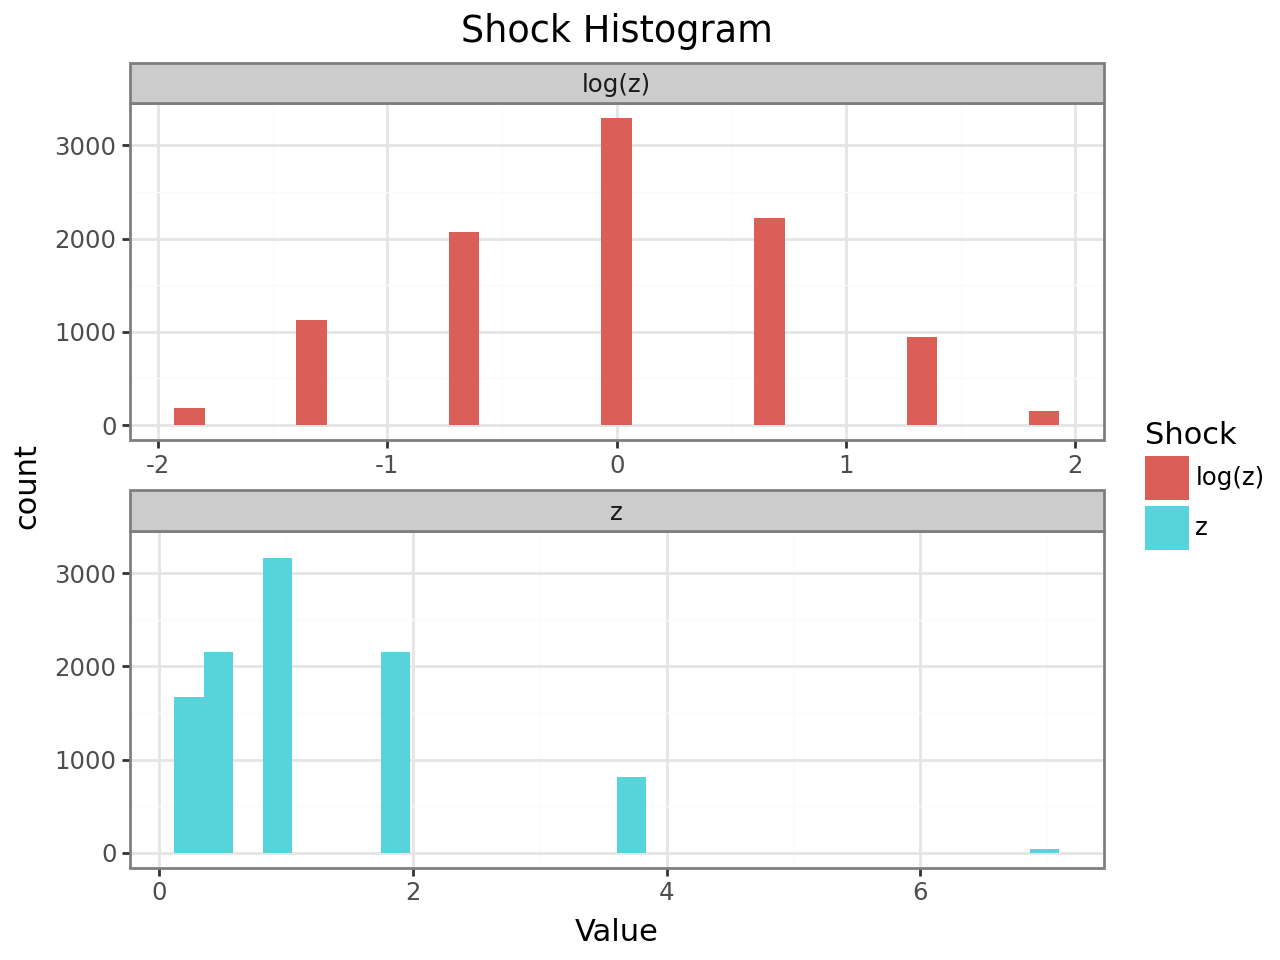

In [201]:
gdf_shocks = pl.DataFrame({
    'log(z)': markov_z_log,
    'z': markov_z
}).unpivot(
    index = None, on = ['log(z)', 'z'],
    variable_name = 'Shock', value_name = 'Value'
)

(
    ggplot(gdf_shocks, aes('Value', fill = 'Shock'))
    + gg.geom_histogram(bins = 30)
    + gg.facet_wrap('Shock', ncol = 1, scales = 'free_x')
    + gg.labs(title = "Shock Histogram")
)

Indeed $z$'s distribution is centered in zero, but with a big variance. $exp(z)$ is an exponential transformation of it, where the values get clumped near zero.

Additionally, we can plot the markov chain itself:

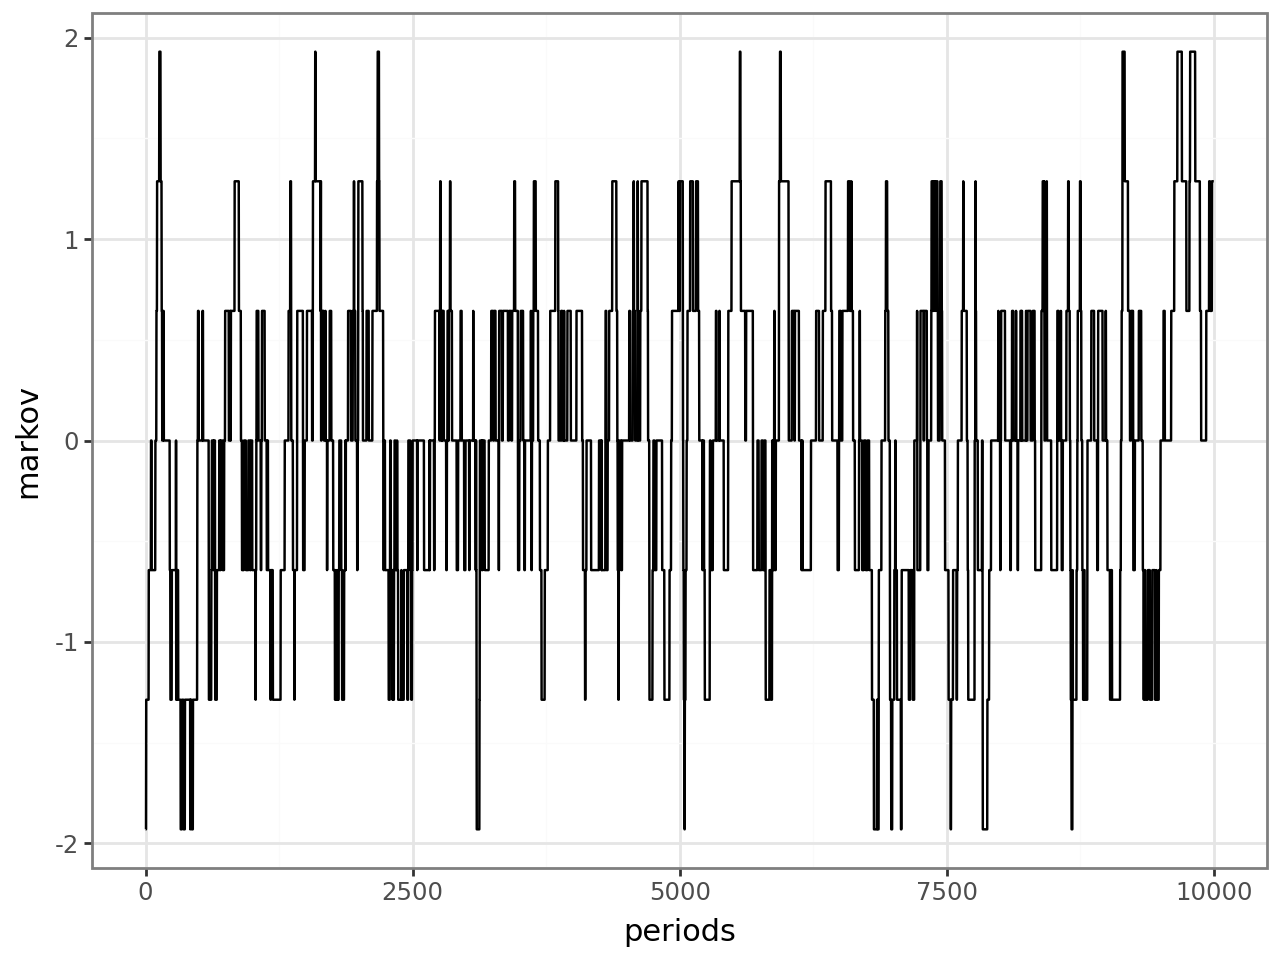

In [202]:
gdf_markov = pl.DataFrame({
  'markov': markov_z_log,
  'periods': range(n_periods)  
})

(ggplot(gdf_markov, aes('periods', 'markov'))
  + gg.geom_line()
)

Now, lets take a step back, and analyze the Rouwenhorst results.

Below, we can see the considered grid. With Tauchen, the range was bigger, less ideally.

In [203]:
z_grid.round(3)

array([0.145, 0.276, 0.525, 1.   , 1.903, 3.621, 6.891])

And lastly, the probability matrix. With Tauchen, the main diagonal elements (of no transition) were very close to one, and at each line, the only other non-zero elements are the lateral transitions. With Rouwenhorst, we have a more spread matrix, with more non-zero elements. To better visualize the difference, the log of the probabilities is plotted.

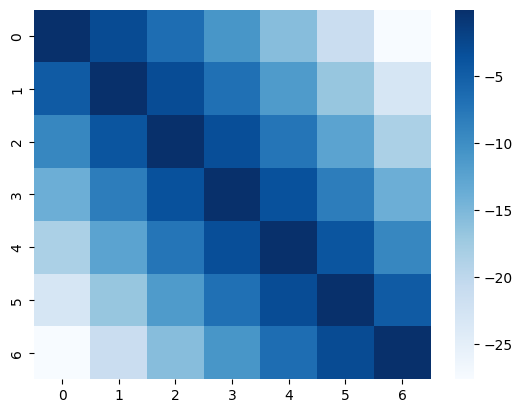

In [205]:
heatmap(np.log(p), annot=False, cmap="Blues")
show()

In conclusion, the Tauchen does not function perfectly, as it present some non-optimal results. Thus, we will use the Rouwenhorst method.

### 1.b)
Each family $i$ chooses its consumption and savings each period, maximizing its life utility, subject to the budget constraint and the productivity shock:

$$
\max_{\left(c_t, a_{t+1}\right)_t} \, E \sum_{t=0}^{\infty} \beta^t \frac{c_t^{1-\sigma}}{1-\sigma}, ~~ s.t
$$
$$
c_t + a_{t+1} \leq z_{i,t} w_t + a_t(1+r_t)$$
$$
\ln z_{t+1} = \rho_z \ln z_t + \epsilon_{t+1}, \quad \epsilon_{t+1} \sim N(0, \sigma_{\epsilon}^2)$$
$$
a_{t+1} \geq -\phi.
$$

Note also that the family cannot save less than a minimum value (no-Ponzi-scheme condition).

We have that:

- $c_t$ is the consumption at time *t*.
- $\beta \in (0, 1)$ is the family's discount factor.
- $a_{t+1}$ is the savings for the next period.
- $z_{i,t}$ is the idiosyncratic labor productivity shock at time *t*.
- $w_t$ is the wage.
- $a_t$ is the asset level at time *t*.
- $r_t$ is the interest rate.
- $\rho_z$ is the persistence parameter.
- $\epsilon_{t+1}$ is a normally distributed shock with zero mean and variance $ \sigma_{\epsilon}^2 $.


Now, lets define the value function, and solve it recursively.

$$
V(z, a) = \max_{a'} \left\{u(c) + \beta E\left[ V(z',a') \mid z\right] \right\},~~ s.t.$$
$$
c + a' \leq wz + (1+r)a, ~~ a' \geq 0, ~~ \ln z' = \rho \ln z + \epsilon' 
$$

We can insert one of the constraints into the problem:

$$
V(z, a) = \max_{c, a'} \left\{u(-a' + wz + (1+r)a) + \beta E\left[ V(z',a') \mid z\right] \right\}, s.t.$$
$$
a' \geq 0, ~~\ln z' = \rho \ln z + \epsilon'
$$

Now, the FOC gets us:

$$
u'(c) = \beta E\left[ V_{a'} (z',a') \mid z\right]
$$

And with the Envelope Condition:

$$
V_{a}(z, a) = (1+r)u'(c)$$
$$
V_{a}(z, a) = (1+r)c^{- \sigma}
$$

### 1.c)

The firm solves:

$$
\max_{K, N} K^\alpha N^{1 - \alpha} - wN - rK
$$

From the FOC, we get the optimal choices' rules:


$$ r = \alpha \left(\frac{K}{N}\right)^\alpha ~~~~ (1)$$

$$ w = (1 - \alpha) \left(\frac{K}{N}\right)^{(1 - \alpha)} ~~~~ (2)$$

Which can be further simplified to:

$$ w = (1 - \alpha) \left(\frac{\alpha}{r}\right)^\frac{\alpha}{1 - \alpha} $$

We were able to solve it analytically, which means we can use these results in the algorithm.

### 1.d)

The RSE is the interest rate $r$, wage $w$, policy function $g(a, z)$, and the stationary distribution $\lambda(a, z)$, such that:

1. Given $r$ and $w$, $g(a, z)$ is the policy function that maximizes the value function. We will find it by iterating the value function on the next item.
2. Given $r$ and $w$, the representative firm maximizes its profits, i.e., $K$ and $N$ are chosen to satisfy the FOC in $(1)$ and $(2)$.
3. Markets clear, i.e., aggregate capital and labor are equal to the sum, in terms of the uncertainty of $a$ and $z$, of individual capital and labor.
4. The stationary distribution $\lambda(a, z)$ is induced by the policy function $g(a, z)$, the transition $P$ and shock $z$.

### 1.e)

Lets define the parameters. Note that $w$ came from the firm's FOC. `n_grid_a` was chosen arbitrarily, by studying the convergence of the algorithm, but had to be set fairly low to avoid the curse of dimensionality.

Additionally, I also define the utility function, with a arbitrarily low result for negative consumption (related to the limit).

In [144]:
r = 0.02
w = (1 - alpha) * (alpha / (r + delta)) ** (alpha / (1 - alpha))

n_grid_a = 350

def get_u(c, sigma):
    u = (c**(1 - sigma) - 1) / (1 - sigma)
    return u if u > 0 else -np.inf

Now, we can define the grid. The max point was set arbitrarily.

In [145]:
a_grid = np.linspace(phi, 200, n_grid_a)

Now, we an define our VF iteration algorithm:

In [146]:
def value_function_iterate(beta):
    # Containers:
    v = np.zeros((n_grid_a, n_grid_z))
    policy_a = np.zeros_like(v)
    policy_c = np.zeros_like(v)

    t0 = time()
    for iter in range(n_iter):
        v_new = np.zeros_like(v)

        for ia, a in enumerate(a_grid):
            for iz, z in enumerate(z_grid):
                # Consumption and utility:
                cs = np.maximum((1 + r) * a + w * z - a_grid, 1e-6)
                us = np.where(cs > 0, (cs ** (1 - sigma)) / (1 - sigma), -np.inf)

                # Updating value:
                continuation = np.dot(p[iz], v.T)
                values = us + beta * continuation

                # Storing results:
                indexes = np.argmax(values)
                v_new[ia, iz] = values[indexes]
                policy_a[ia, iz] = a_grid[indexes]
                policy_c[ia, iz] = cs[indexes]

        # Convergence check:    
        if np.max(np.abs(v_new - v)) < tol:
            return {
                'a': policy_a,
                'c': policy_c,
                'iters': iter,
                'time': time() - t0
            }
        
        v = v_new.copy() #else, update v
    
    return None  

Finally, lets apply it, and get its results.

In [147]:
result_vf1 = value_function_iterate(beta = beta)

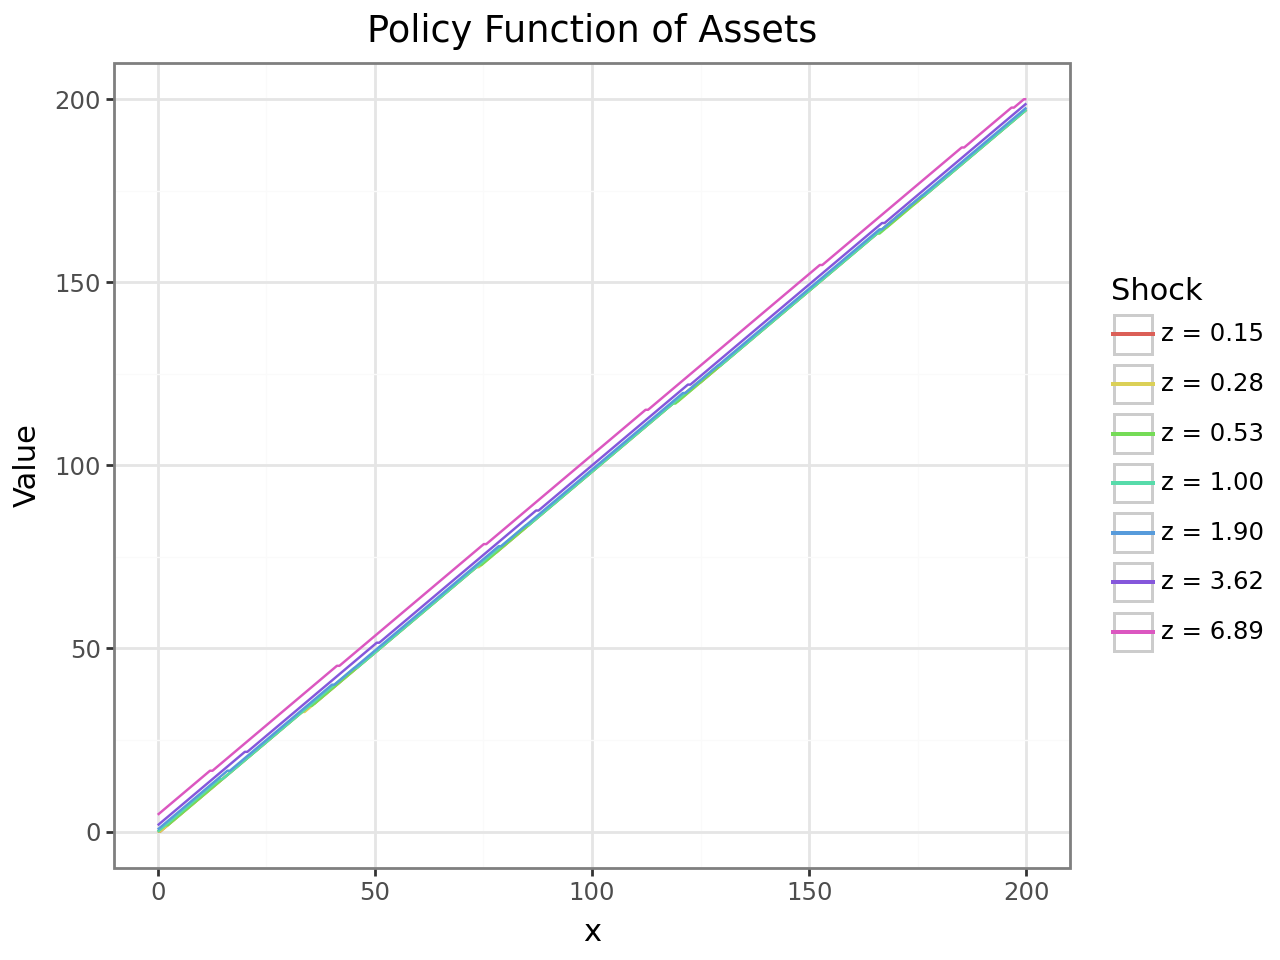

In [148]:
plot_policy(result_vf1['a'], 'Assets')

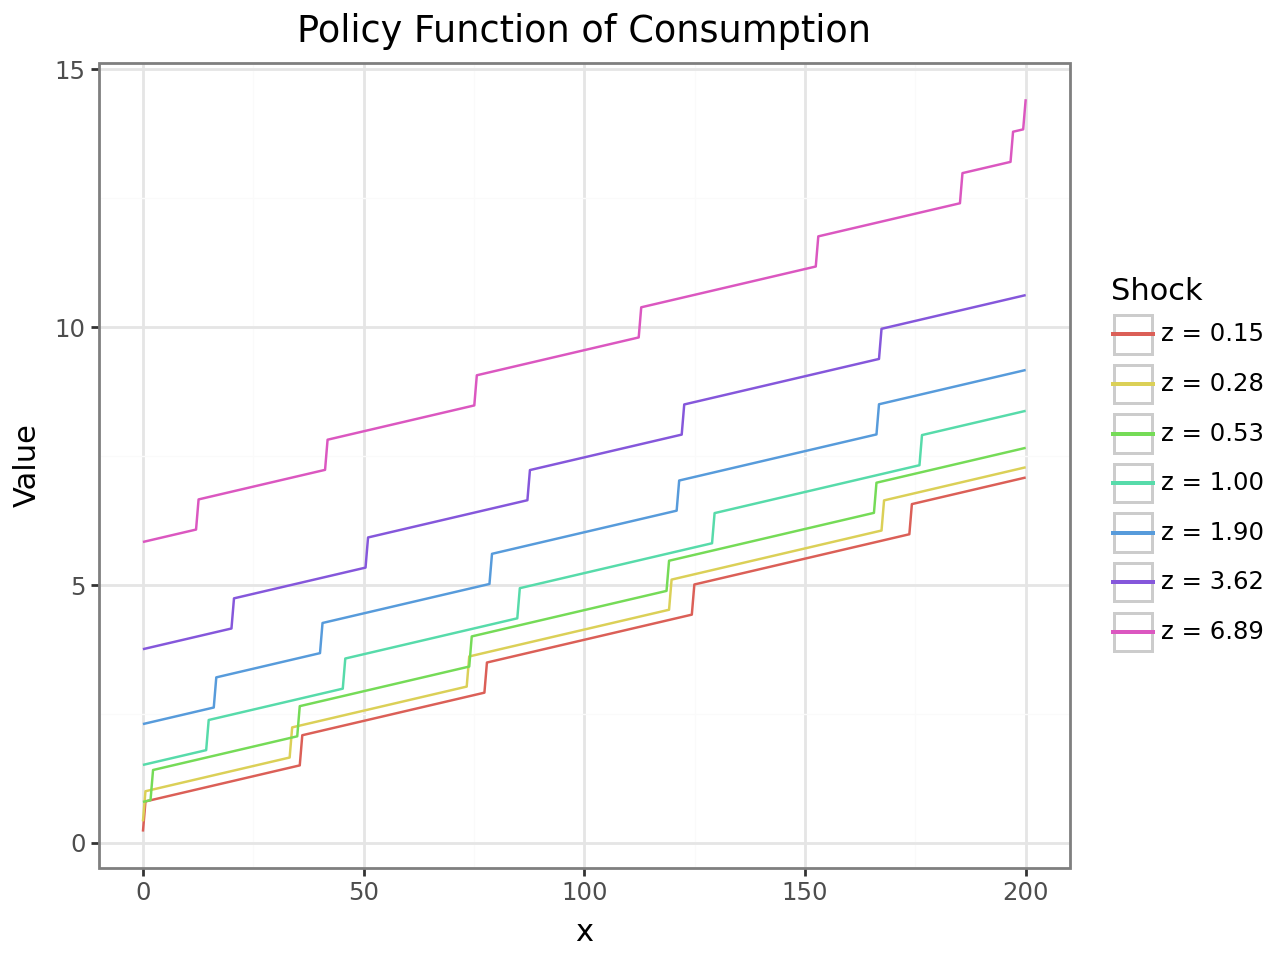

In [149]:
plot_policy(result_vf1['c'], 'Consumption')

Now, lets run the code for $\beta = 0.975$:

In [150]:
result_vf2 = value_function_iterate(beta = 0.975)

The same graphs can be plotted, by `plot_policy(result_vf1['a'])` and `plot_policy(result_vf1['c'])`.

But we are interested in the time difference. We can see that the lower beta takes approximately $1.5$ times the time of the higher beta.

In [151]:
print(f'Time beta (0.98 vs 0.975): {result_vf1["time"]:.2f} vs {result_vf2["time"]:.2f}')
print(f'Rime ratio: {result_vf2["time"] / result_vf1["time"]:.2f}')

Time beta (0.98 vs 0.975): 22.77 vs 35.02
Rime ratio: 1.54


### 1.f)

Now, we need to create the algorithm for the EGM. Now, we are going to use directly the policy functions, creating the grids in a endogenous, more effective, method, which speeds up the time.

The commented code is the more traditional loop-based code, whereas the uncommented code above is the vectorized version, which is faster.

In [152]:
def edm_iterate(beta):
    # Containers:
    policy_a = np.zeros((n_grid_a, n_grid_z))
    policy_c = np.zeros((n_grid_a, n_grid_z))

    t0 = time()
    for iz, z in enumerate(z_grid):
        ap = a_grid.copy()
        cp = (1 + r) * ap + w * z
 
        for iter in range(n_iter):
            # Utility and Expected utility:
            up_cp = ((1 + r) * ap[:, np.newaxis] + w * z_grid) ** (-sigma)
            #up_cp = np.zeros((n_grid_a, n_grid_z))
            #for izp, zp in enumerate(z_grid): up_cp[:, izp] = ((1 + r) * ap + w * z) ** (-sigma)
            
            up_cp_expected = np.dot(up_cp, p[iz, :])
            #up_cp_expected = np.zeros(n_grid_a)
            #for ia, a in enumerate(a_grid):
            #    up_cp_expected[ia] = np.dot(p[iz, :], up_cp[ia, :])
            
            # Consumption and assets, from Euler and BC:
            c = (beta * (1 + r) * up_cp_expected) ** (-1 / sigma)
            a = (c + ap - w * z) / (1 + r)

            # Guaranteeing monotonicity and filling values:
            a_mono = np.maximum(a, a_grid[0])
            cp = interp1d(a_mono,
                c, fill_value = 'extrapolate', bounds_error = False
            )(ap)

            # Convergence check:    
            if np.max(np.abs(cp - c)) < tol:
                break
        
        policy_a[:, iz] = ap
        policy_c[:, iz] = cp
        
    return  {
                'a': policy_a,
                'c': policy_c,
                'time': time() - t0
            }  

Lets apply it and get the results.

In [153]:
result_edm1 = edm_iterate(beta)

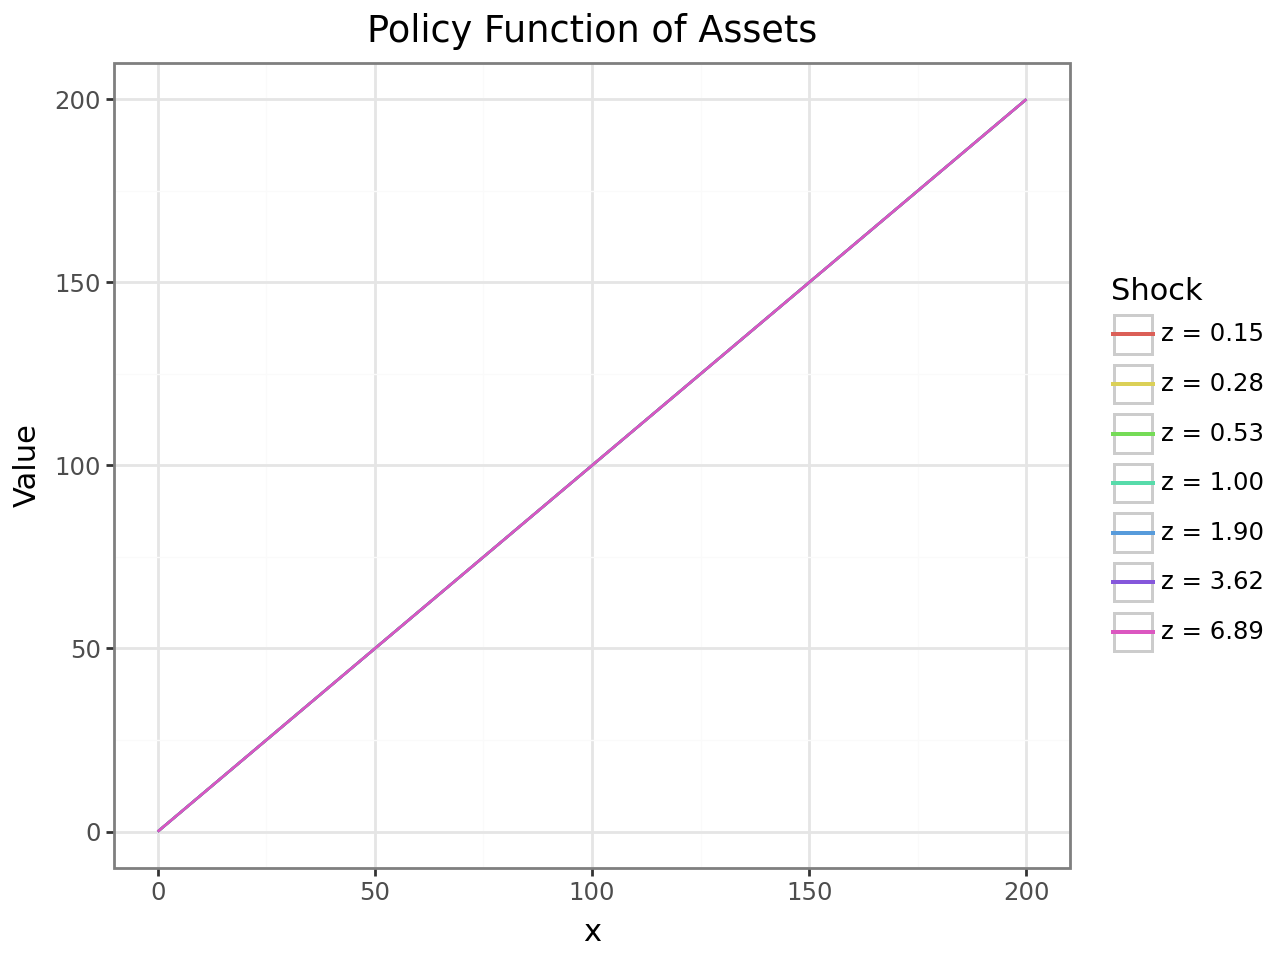

In [154]:
plot_policy(result_edm1['a'], 'Assets')

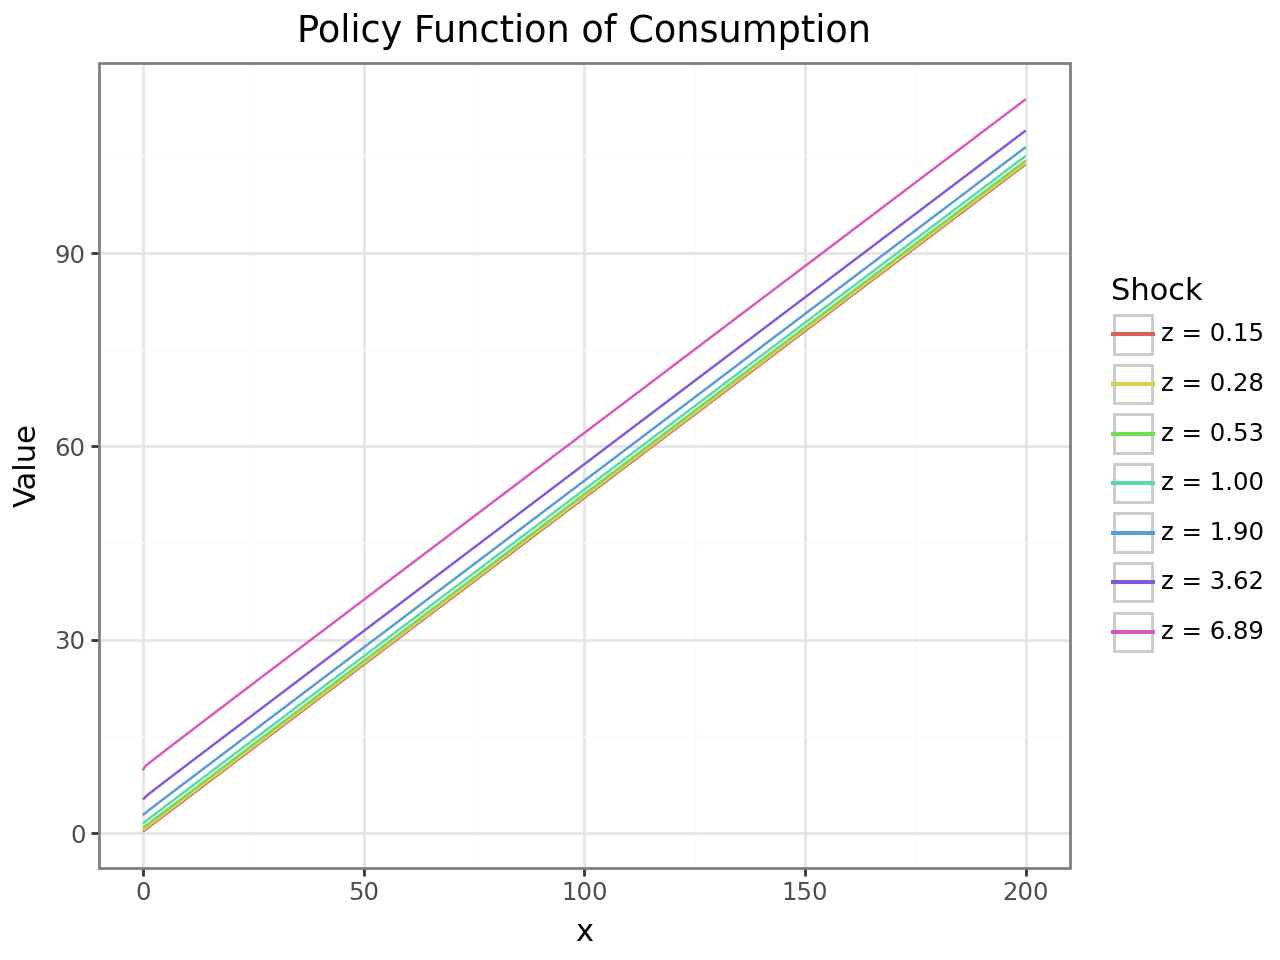

In [155]:
plot_policy(result_edm1['c'], 'Consumption')

While the policy function fo the assets is very similar from the VFI method, the consumption is different, in that it's slope is bigger. This is an indication of a possible incorrect divergence between the implementation of the two methods.

At least, the format of the functions is similar. It is also important to note that the EGM method is much faster.

Now, lets run it with $\beta = 0.975$:

In [156]:
result_edm2 = edm_iterate(beta = 0.975)

The same graphs can be plotted, by `plot_policy(result_vf1['a'])` and `plot_policy(result_vf1['c'])`.

But we are interested in the time difference. We can see that there isn't much of a significant difference between the two betas.

We would expect the lower beta to take more time, but, the EGM is a very time-efficient method, decreasing the effect of the difference in betas.

In [157]:
print(f'Time beta (0.98 vs 0.975): {result_edm1["time"]:.2f} vs {result_edm2["time"]:.2f}')
print(f'Rime ratio: {result_edm2["time"] / result_edm1["time"]:.2f}')

Time beta (0.98 vs 0.975): 2.04 vs 1.72
Rime ratio: 0.85


### 1.g)

Recall the algorithm:

1. Guess an interest rate $r \in (-\delta, \frac{1}{\beta} - 1)$, get $\tilde r = r + \delta$ and the $w$ from the firm's FOC.
2. Get the aggregated capital from the equilibrium condition.
3. Solve the household problem, getting the policy function $g(a, z)$ and the stationary distribution $\lambda(a, z)$.
4. Find $e_K = K - \sum_{a, z} \lambda(a, z)a$.
5. Apply the bisection method: if $e_K > 0$, set $r' > r$, and vice versa. Stop when $|e_K|$ is small enough.`

Lets define a function to get the stationary distribution. Again, the commented code is the more traditional loop-based code, whereas the uncommented code above is the vectorized version, which is faster.

In [158]:
#def get_distribution(policy_a, policy_c):
#    dist = np.ones((n_grid_a, n_grid_z)) / (n_grid_a * n_grid_z)
#
#    for iter in range(n_iter):
#        distp = np.zeros_like(dist)
#
#        for ia in range(n_grid_a):
#            for iz in range(n_grid_z):
#                ap = policy_a[ia, iz]
#                index = np.searchsorted(a_grid, ap)
#                distp[index, :] += p[iz, :] * dist[ia, iz]
#        
#        if np.max(np.abs(distp - dist)) < tol:
#            break
#        dist = distp.copy()
#
#    return dist

def get_distribution(policy_a, policy_c):
    dist = np.ones((n_grid_a, n_grid_z)) / (n_grid_a * n_grid_z)

    for iter in range(n_iter):
        distp = np.zeros_like(dist)

        ap = policy_a.flatten()
        indices = np.searchsorted(a_grid, ap).reshape(n_grid_a, n_grid_z) #np.clip?

        for iz in range(n_grid_z):
            distp[indices[:, iz], :] += p[iz, :] * dist[:, iz][:, np.newaxis]

        if np.max(np.abs(distp - dist)) < tol:
            break
        dist = distp.copy()

    return dist

Now, a function to get the equilibrium, following the presented algorithm.

This is also a very important function to optimize. I thought that, at the start of the iterations, we can take big steps changing the interest rate, and as we get closer to the equilibrium, we want a finer control.

Thus, I implemented the `if ep < e: add = add /10` logic, where we decrease the step size ase we go on. When do we decrease it? When the last iteration error `ep` was smaller, i.e., we overshoot our guess.

To show how it works, I will plot information on the iterations. Note that a new decimal place is affected after a bad guess.

Obs: this method was shared with colleagues.

In [159]:
def get_eq(init, n_iter = 100, tol = 1e-5, add = 0.005):
    r = init
    ep = np.inf

    for iter in range(n_iter):
        w = (1 - alpha) * (alpha / (r + delta)) ** (alpha / (1 - alpha))
        result_edm = edm_iterate(beta)
        dist = get_distribution(result_edm['a'], result_edm['c'])

        a_supply = np.sum(dist * a_grid[:, np.newaxis])
        a_demand = (alpha / (r + delta)) ** (1 / (1 - alpha))

        e = np.abs(a_supply - a_demand)
        print(f'Iter {iter + 1:04} -- r = {r:+.8f} -- e = {e:07.5f}')

        if e < tol: break

        if ep < e: add = add /10
        r += add if a_supply < a_demand else -add

        ep = e
    
    return {
        'r': r,
        'w': w,
        'a': result_edm['a'],
        'c': result_edm['c'],
        'dist': dist,
        'iters': iter,
        'e': e
    }       

In [160]:
result_eq = get_eq(-0.045)

Iter 0001 -- r = -0.04500000 -- e = 42.01443
Iter 0002 -- r = -0.05000000 -- e = 25.02821
Iter 0003 -- r = -0.05500000 -- e = 1.59367
Iter 0004 -- r = -0.05000000 -- e = 25.02821
Iter 0005 -- r = -0.05050000 -- e = 22.89842
Iter 0006 -- r = -0.05100000 -- e = 20.67015
Iter 0007 -- r = -0.05150000 -- e = 18.33702
Iter 0008 -- r = -0.05200000 -- e = 15.89214
Iter 0009 -- r = -0.05250000 -- e = 13.32800
Iter 0010 -- r = -0.05300000 -- e = 10.63646
Iter 0011 -- r = -0.05350000 -- e = 7.80865
Iter 0012 -- r = -0.05400000 -- e = 4.83489
Iter 0013 -- r = -0.05450000 -- e = 1.70464
Iter 0014 -- r = -0.05500000 -- e = 1.59367
Iter 0015 -- r = -0.05450000 -- e = 1.70464
Iter 0016 -- r = -0.05455000 -- e = 1.38257
Iter 0017 -- r = -0.05460000 -- e = 1.05881
Iter 0018 -- r = -0.05465000 -- e = 0.73335
Iter 0019 -- r = -0.05470000 -- e = 0.40617
Iter 0020 -- r = -0.05475000 -- e = 0.07726
Iter 0021 -- r = -0.05480000 -- e = 0.25339
Iter 0022 -- r = -0.05479500 -- e = 0.22025
Iter 0023 -- r = -0.054

Now, lets analyze the results. First the equilibrium values:

In [161]:
f'Equilibrium wage: {result_eq['w']:.2f} -- \
Equilibrium interest rate: {result_eq['r']:.4f}'

'Equilibrium wage: 3.79 -- Equilibrium interest rate: -0.0548'

Additionally, we can see several interesting metrics. For example, the investment rate and capital to output ratio:

In [162]:
k = np.sum(result_eq['dist'] * a_grid[:, np.newaxis])
n = np.sum(result_eq['dist'] * z_grid)

y = k ** alpha * n ** (1 - alpha)

f'Investment rate: {delta * k / y:.4f} -- Capital to output ratio: {k / y:.4f}'

'Investment rate: 1.0470 -- Capital to output ratio: 13.0878'

The aggregated income and wealth:

In [163]:
income = result_eq['r'] * a_grid[:, np.newaxis] +\
    result_eq['w'] + z_grid[np.newaxis, :]
wealth = result_eq['dist'] * a_grid[:, np.newaxis]

f'Agg. Income: {np.sum(income):.4f} -- Agg. Wealth: {np.sum(wealth):.4f}'

'Agg. Income: 885.3596 -- Agg. Wealth: 100.0000'

And inequality measures such as the Gini coefficient:

In [164]:
def gini(x, dist):
    x, dist = x.flatten(), dist.flatten()

    indexes = np.argsort(x)
    x_sorted, dist_sorted = x[indexes], dist[indexes]

    curve_cum = np.cumsum(x_sorted * dist_sorted)
    curve_cum_norm = curve_cum / np.sum(dist_sorted)

    trap = np.trapezoid(curve_cum_norm, curve_cum)

    gdf = pl.DataFrame({
        'dist': np.cumsum(dist_sorted),
        'dist cum': curve_cum_norm
    })

    plot = (
        ggplot(gdf, aes('dist', 'dist cum'))
        + gg.geom_segment(aes(0, 0, xend = 1, yend = 1), linetype = 'dashed')
        + gg.geom_ribbon(aes(y = 'dist', ymin = 'dist cum', ymax = 'dist'), alpha = 0.5)
        + gg.geom_line()
    )

    return {'gini': 1 - 2 * trap, 'plot': plot}

0.9010081516742607


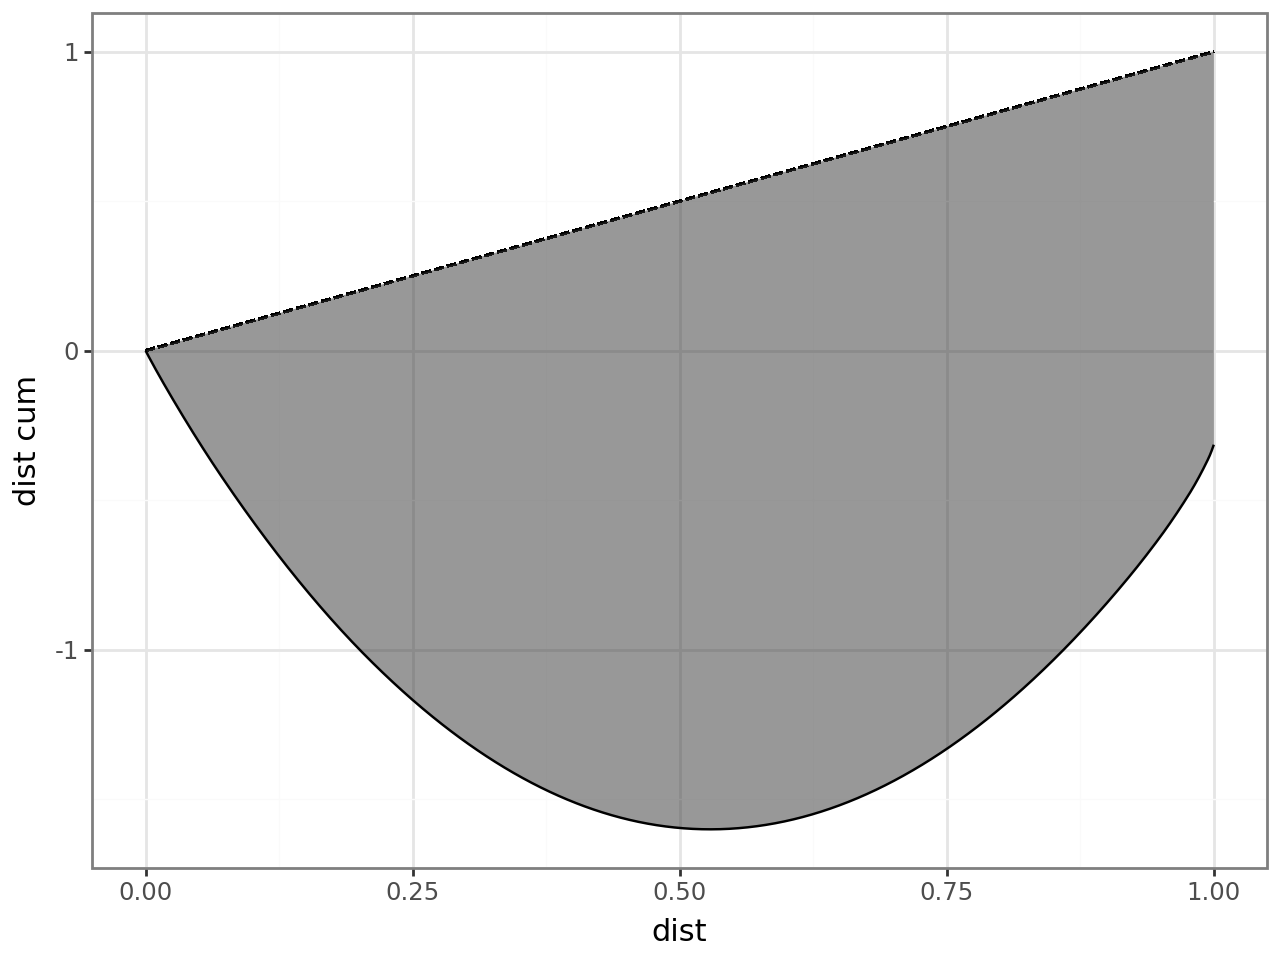

In [165]:
result_gini = gini(income, result_eq['dist'])
print(result_gini['gini'])
result_gini['plot'].show()

0.9960526436559852


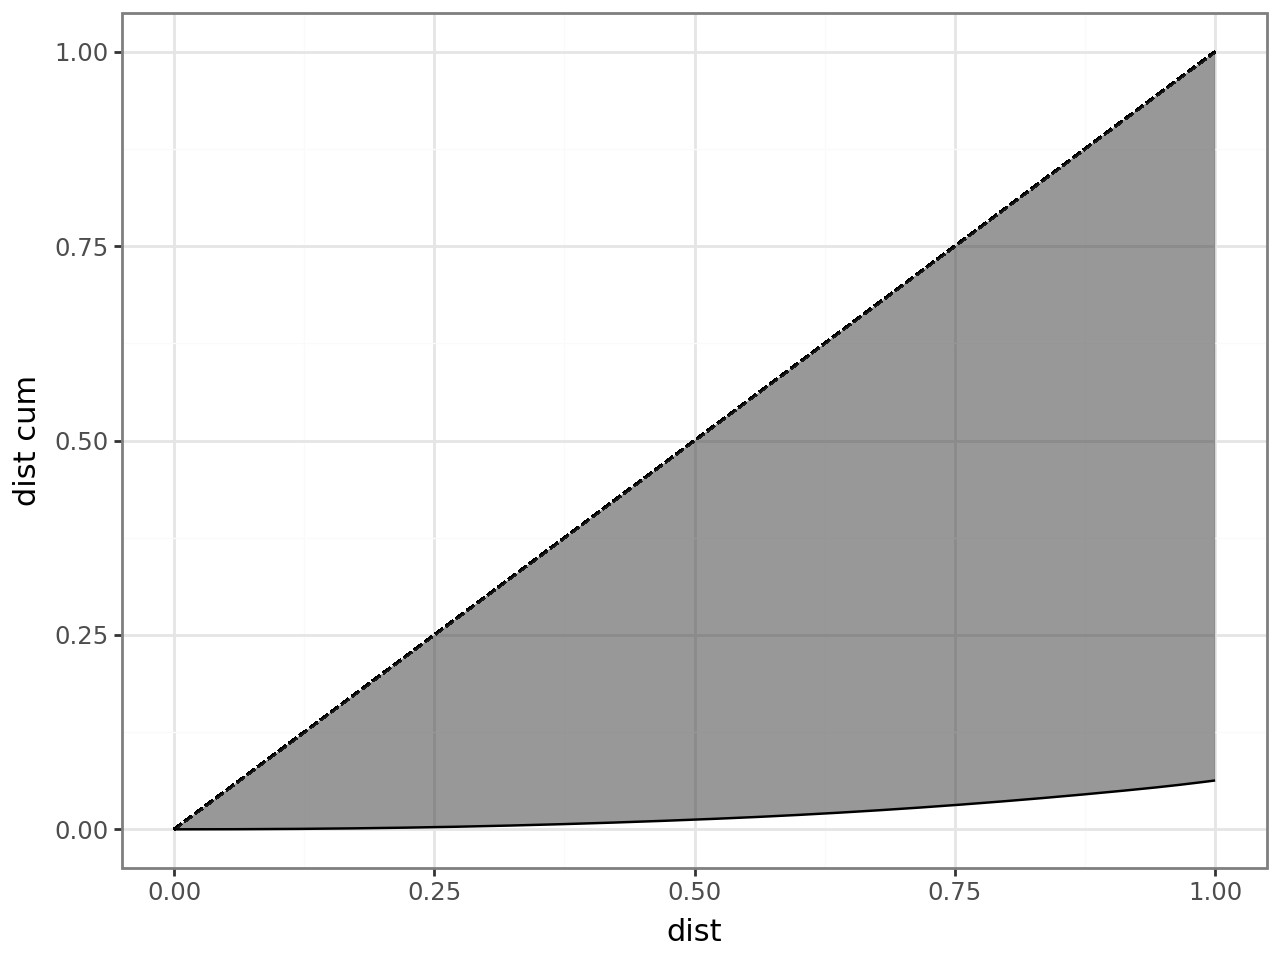

In [166]:
res = gini(wealth, result_eq['dist'])
print(res['gini'])
res['plot'].show()

### 1.h)

Here we are very dependent of an optimized `get_eq` function, which is why I spent a large amount of time on it. I also optimized the guess `guess` and step `add` for each of the following questions.

Then, we can guess the $r$ that solves the model, and see if it is higher of smaller than the target, adjusting the $\beta$ accordingly (i.e. finding it via bisection).

I ran the code to check that it worked, but did not run for it completion, as it would've taken too long.

In [167]:
def calibrate_beta(target, guess, add):
    beta_min, beta_max = 0, 0.4

    for iter in range(n_iter):
        beta = (beta_min + beta_max) / 2
        result_eq = get_eq(guess, add = add) #beta passed implicitly

        print(f'Iter {iter + 1:03} -- beta = {beta:07.5f} -- r = {r:+.3f}')
        if result_eq['r'] > target: beta_min = beta
        else: beta_max = beta

        if np.abs(result_eq['r'] - target) < tol: break
    
    return beta

#beta_target = calibrate_beta(0.04, 0.06, tol = 0.3, 0.005)

### 1.i)

The algorithm is very similar, but we need a new bound, and a new object of interest.

I ran the code to check that it worked, but did not run for it completion, as it would've taken too long.

In [168]:
def calibrate_sigma_z(target, guess, add):
    sigma_z_min, sigma_z_max = 0, 1

    for iter in range(n_iter):
        sigma_z = (sigma_z_min + sigma_z_max) / 2
        result_eq = get_eq(guess, add = add) #sigma_z passed implicitly

        wealth = result_eq['dist'] * a_grid[:, np.newaxis]
        ratio = np.percentile(wealth, 90) / np.percentile(wealth, 10)

        print(f'Iter {iter + 1:03} -- sigma_z = {sigma_z:07.5f} -- ratio = {ratio:+.3f}')
        if ratio > target: sigma_z_min = sigma_z
        else: sigma_z_max = sigma_z

        if np.abs(ratio - target) < tol: break
    
    return sigma_z ^ 2

#sigma_z_target = calibrate_sigma_z(7, 0.002, 0.1)   

### 1.j)

Now, we will combine both of the above. I did not used GMM method.

For each iteration of the $\beta$ bisection, we will do a $\sigma_z$ bisection. It is clear that it is a very time-consuming approach, almost unfeasible, hence the benefit of GMM.

I ran the code to check that it worked, but did not run for it completion, as it would've taken too long.

In [169]:
def calibrate_joint2(target, guess, add):
    beta_min, beta_max = 0, 0.4

    for iter in range(n_iter):
        beta = (beta_min + beta_max) / 2

        sigma_z_min, sigma_z_max = 0, 1
        for iter in range(n_iter):
            sigma_z = (sigma_z_min + sigma_z_max) / 2
            result_eq = get_eq(guess[0], add = add[1]) #beta and sigma_z passed implicitly
    
            wealth = result_eq['dist'] * a_grid[:, np.newaxis]
            ratio = np.percentile(wealth, 90) / np.percentile(wealth, 10)
    
            print(f'Iter {iter + 1:03} -- sigma_z = {sigma_z:07.5f} -- ratio = {ratio:+.3f}')
            if ratio > target[0]: sigma_z_min = sigma_z
            else: sigma_z_max = sigma_z
    
            if np.abs(ratio - target) < tol: break
        
        result_eq = get_eq(guess[1], add = add[0]) #beta passed implicitly

        print(f'Iter {iter + 1:03} -- beta = {beta:07.5f} -- r = {r:+.3f}')
        if result_eq['r'] > target[1]: beta_min = beta
        else: beta_max = beta

        if np.abs(result_eq['r'] - target) < tol: break
    
    return beta, sigma_z ^ 2

#joint2_target = calibrate_joint2((0.04, 7), (0.05, 0.002), (0.005, 0.1))   

### 1.k)

Again, a similar bisection logic as before, with new object of interest and optimizations.

I ran the code to check that it worked, but did not run for it completion, as it would've taken too long.

In [170]:
def calibrate_phi(target, guess, add):
    phi_min, phi_max = 0.8, 0.99

    for iter in range(n_iter):
        phi = (phi_min + phi_max) / 2
        result_eq = get_eq(guess, add = add) #phi passed implicitly

        income = result_eq['r'] * a_grid[:, np.newaxis] +\
            result_eq['w'] + z_grid[np.newaxis, :]
        debt = np.sum(result_eq['c'] - income)
        ratio = debt / income

        print(f'Iter {iter + 1:03} -- phi = {phi:07.5f} -- ratio = {ratio:+.3f}')
        if ratio > target: phi_min = phi
        else: phi_max = phi

        if np.abs(ratio - target) < tol: break
    
    return phi ^ 2

#phi_target = calibrate_phi(0.1, 0.9, 0.05)   

### 1.l)

Same approach as in 1.j, but with a new iteration level.

Again, even more time consuming, which is why GMM is basically a necessity at this point.

In [171]:
def calibrate_joint3(target, guess, add):
    beta_min, beta_max = 0, 0.4

    for iter in range(n_iter):
        beta = (beta_min + beta_max) / 2

        sigma_z_min, sigma_z_max = 0, 1
        for iter in range(n_iter):
            sigma_z = (sigma_z_min + sigma_z_max) / 2

            phi_min, phi_max = 0.8, 0.99
            for iter in range(n_iter):
                phi = (phi_min + phi_max) / 2
                result_eq = get_eq(guess[2], add = add[2]) #all 3 passed implicitly
        
                income = result_eq['r'] * a_grid[:, np.newaxis] +\
                    result_eq['w'] + z_grid[np.newaxis, :]
                debt = np.sum(result_eq['c'] - income)
                ratio = debt / income
        
                print(f'Iter {iter + 1:03} -- phi = {phi:07.5f} -- ratio = {ratio:+.3f}')
                if ratio > target: phi_min = phi
                else: phi_max = phi
        
                if np.abs(ratio - target) < tol: break

            result_eq = get_eq(guess[0], add = add[1]) #beta and sigma_z passed implicitly
    
            wealth = result_eq['dist'] * a_grid[:, np.newaxis]
            ratio = np.percentile(wealth, 90) / np.percentile(wealth, 10)
    
            print(f'Iter {iter + 1:03} -- sigma_z = {sigma_z:07.5f} -- ratio = {ratio:+.3f}')
            if ratio > target[0]: sigma_z_min = sigma_z
            else: sigma_z_max = sigma_z
    
            if np.abs(ratio - target) < tol: break
        
        result_eq = get_eq(guess[1], add = add[0]) #beta passed implicitly

        print(f'Iter {iter + 1:03} -- beta = {beta:07.5f} -- r = {r:+.3f}')
        if result_eq['r'] > target[1]: beta_min = beta
        else: beta_max = beta

        if np.abs(result_eq['r'] - target) < tol: break
    
    return beta, sigma_z ^ 2

#joint3_target = calibrate_joint3((0.04, 7, 0.1), (0.05, 0.002, 0.8), (0.005, 0.1, 0.05))    

## Question 2.

In this question, we will deal with the Hopenhayn model.

### 2.a)

Lets derive the profit function.

The incumbent firm solves:

$$
\pi(z)=\max _{n}\left\{py - nw -\kappa\right\}
$$

Where $p$ is the price and $\kappa$ is the fixed cost.

Taking into consideration the production function, the productivity shock $z$, and $w = 1$, we have:

$$
\pi(z)=\max _{n}\left\{pzn^\alpha - n -\kappa\right\}, ~~ s.t.
$$
$$
\ln{z_{t+1}} = (1 -\rho) \ln{\bar{z}} + \sigma\epsilon_{t+1}
$$

Now, we can take the FOC:

$$
\alpha pzn^{\left(\alpha-1 \right)} - 1 = 0$$
$$
\alpha pzn^{\left(\alpha-1 \right)} = 1$$
$$
n^* = \left(\alpha pz \right)^{\frac{1}{\left(1 - \alpha \right)}}
$$

Thus, the per-period profit is:

$$
\pi^{*}(z)= pz\left(\alpha pz\right)^{\frac{\alpha}{1-\alpha}}-\left(\alpha pz\right)^{\frac{1}{1-\alpha}}-\kappa
$$

### 2.b)

Lets begin by setting the parameters. Note that we increased tolerance as this question is less computationally intensive.

In [292]:
# Main parameters:
beta = 0.8
alpha = 2/3
sigma = 0.2
d = 100
kappa = 20
rho = 0.9

# Utility parameters:
n_grid_z = 33
tol = 1e-7

Again, we have a very high persistence, so we will use the Rouwenhorst method.

In [293]:
result_approx = quant.rouwenhorst(n_grid_z, rho, mu = 0, sigma = sigma)

p = result_approx.P
z_grid_log = result_approx.state_values
z_grid = np.exp(z_grid_log)

C:\Users\ricar\AppData\Local\Temp\ipykernel_20108\2695874988.py:1: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.


An observation: it would probably be better suited to use a custom function to get the grid, as the AR(1) process is more complex, and has the $(1 - \rho) \ln \bar z$ term. That could be done by setting a state space (with `np.linspace`) and creating a transition matrix following the process and using `scipy.stats.norm.cdf` to get the probabilities.
1
That would be a custom Tauchen method, which, although would be more in line with the exercise, would still suffer from the high persistence. I choose to keep using the Rouwenhorst method.

Now, we need a function to get the stationary distribution, by iteration-aly updating the distribution:

In [294]:
def get_markov_ss_dist(transition, tol = 1e-8):
    transition = transition.T
    markov = np.ones(len(transition)) / len(transition)  
    error = np.inf

    for iter in range(n_iter):
        markov_next = np.dot(transition, markov)
        error = np.max(np.abs(markov_next - markov))
        markov = markov_next
        if error < tol: break

    return markov

In [295]:
p_ss = get_markov_ss_dist(p)

We can show some descriptive statistics. The mean is, as expected, very close to zero.

In [296]:
mean = np.dot(z_grid_log, p_ss)
f'SD of MC: {np.sqrt(np.dot((z_grid_log - mean) ** 2, p_ss)):.4f}'

'SD of MC: 0.4588'

Our goal now is to find the equilibrium. Lets use VFI to get the incumbent value, and bisection to get the equilibrium price equaling demand and supply. We can also get the distribution with bisection.

First, some helper functions:

In [297]:
def get_firm_choice(price):
    labor = ((alpha * price * z_grid)) ** (1 / (1 - alpha))
    profit = price * z_grid * (labor ** alpha) - labor - kappa
    return labor, profit

def get_entrant_index(v):
    return np.searchsorted(np.ones(n_grid_z) * (np.dot(p, v) >= 0), 1)

And now, the main ones:

In [298]:
def vif_incumbent(price, n_iter = 1000):
    v = np.zeros(n_grid_z)
    v_next = np.zeros_like(v)

    labor, profit = get_firm_choice(price)

    for iter in range(n_iter):
        vf_next = profit + beta * np.maximum(np.dot(p, v), 0)
        if np.max(np.abs(vf_next - v)) < tol: break
        v = np.copy(vf_next)

    return v

def bisec_price(price_min = 0.01, price_max = 10, n_iter = 1000):
    for iter in range(n_iter):
        price = (price_min + price_max) / 2
        v_incumbent = vif_incumbent(price)
        v_entrant = -kappa_e + beta * np.dot(v_incumbent, p_ss)

        if v_entrant > 0:
            price_max = price
        else:
            price_min = price

        if price_max - price_min < tol: break

    return price, v_incumbent

def bisec_distribution(d, m_min = 0.001, m_max = 1.0, n_iter = 1000):
    price, v_incumbent = bisec_price()
    labor, profit = get_firm_choice(price)
    index = get_entrant_index(v_incumbent)

    demand = d / price
    p_incumbent = p.copy()
    p_incumbent[0:index, :] = 0

    for iter in range(n_iter):
        m = (m_min + m_max) / 2
        mu = np.ones(n_grid_z) / n_grid_z

        for iter in range(n_iter):
            mu_next = mu.dot(p_incumbent) + m * p_ss
            if np.max(np.abs(mu_next - mu)) < tol: break
            mu = mu_next
        
        supply = mu @ (z_grid * labor ** alpha)
        if supply > demand:
            m_max = m
        else:
            m_min = m

        if np.abs(supply - demand) < tol: break

    return m, mu

Now, lets find the results.

In [299]:
result_price = bisec_price()
result_dist = bisec_distribution(d)
labor, profit = get_firm_choice(result_price[0])
index = get_entrant_index(result_price[1])

f'Equilibrium price: {result_price[0]:.3f} -- \
Equilibrium entrants: {result_dist[0]:.3f} -- \
Productivity to leave: {z_grid[index]:.3f}'

'Equilibrium price: 4.057 -- Equilibrium entrants: 0.079 -- Productivity to leave: 1.000'

We can also plot the distributions of productivity and of employment:

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


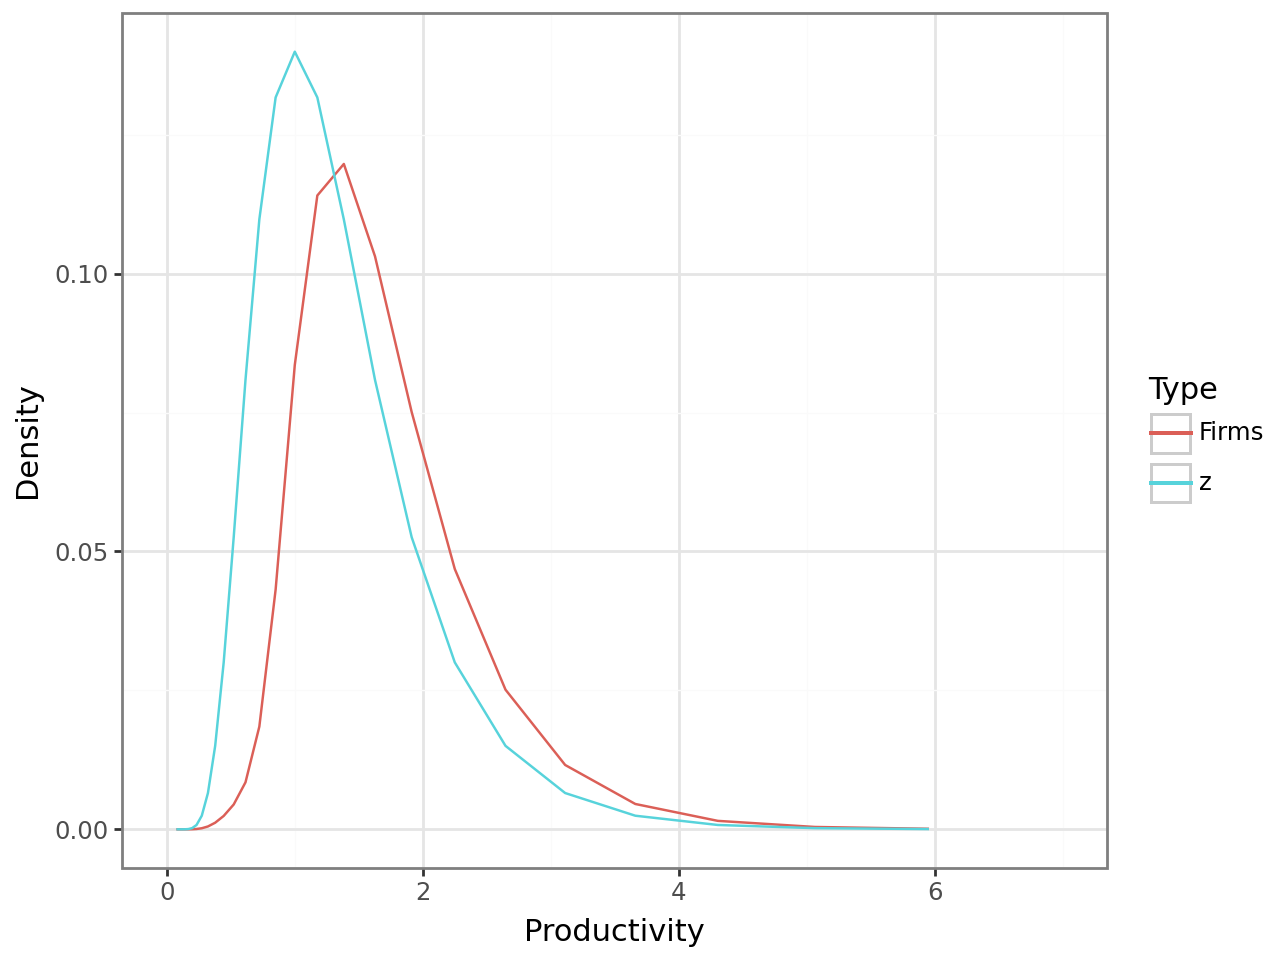

In [300]:
gdf_dist = pl.DataFrame({
    'Productivity': z_grid,
    'Firms': result_dist[1],
    'z': p_ss
}).unpivot(
    index = 'Productivity', on = ['Firms', 'z'],
    variable_name = 'Type', value_name = 'Density'
)

(
    ggplot(gdf_dist, aes('Productivity', 'Density', color = 'Type'))
    + gg.geom_line()
    + gg.xlim(0, 7)
)

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


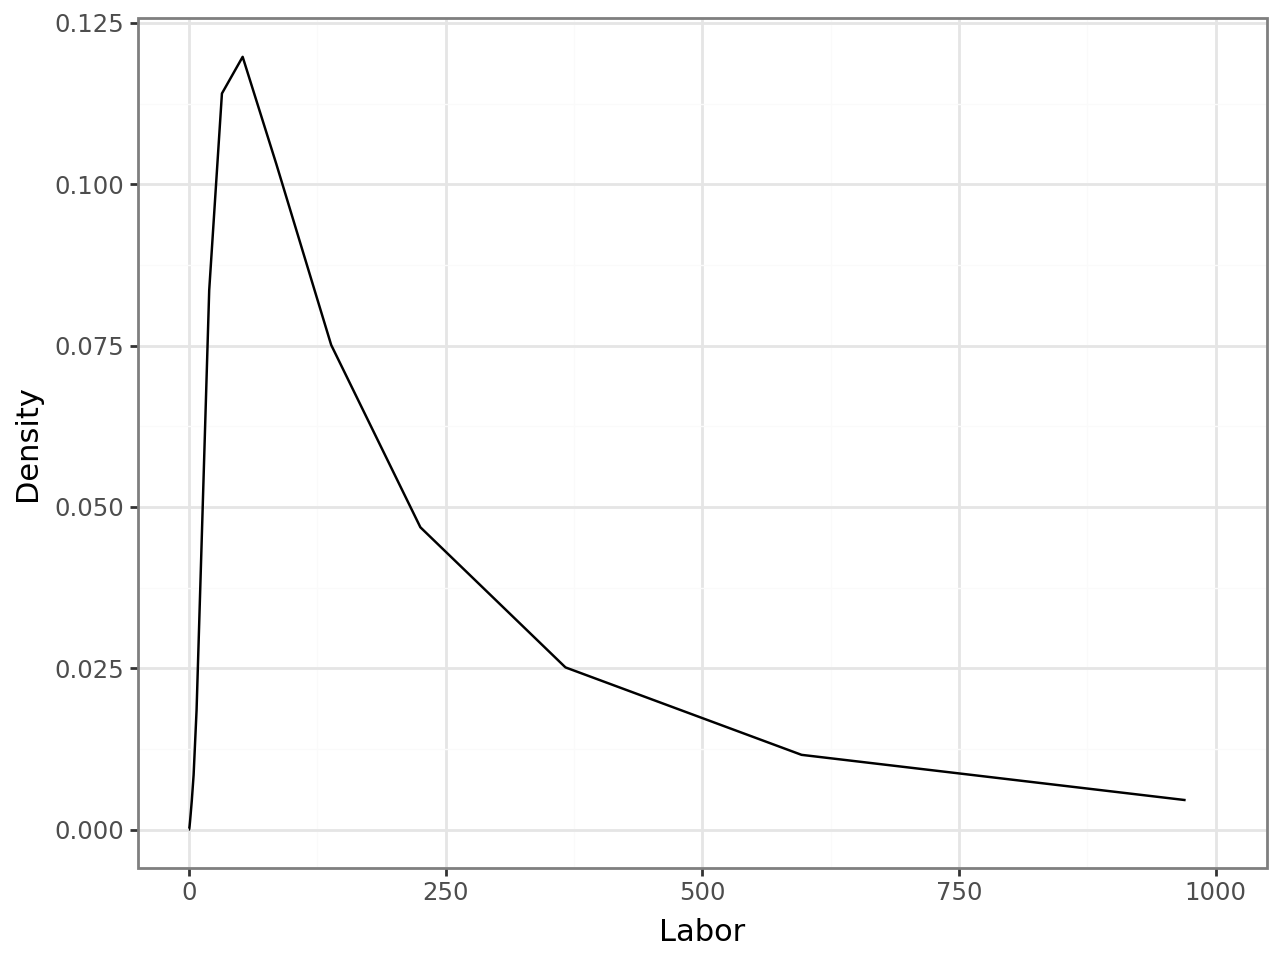

In [301]:
gdf_dist2 = pl.DataFrame({
    'Density': result_dist[1],
    'Labor': labor
})

(
    ggplot(gdf_dist2, aes('Labor', 'Density'))
    + gg.geom_line()
    + gg.xlim(0, 1000)
)

We can see that the stationary distribution of firms is concentrated near median values, and the productivity shock has higher density near the initial values. They indeed have similar peaks, but the firms' is less concentrated, with a more relevant tail.

The employment distribution indicates an expected result: most firms have a small number of jobs, and bigger firms get rare fast.

### 2.c)

Lets set `d = 120` and compare the results.

In [302]:
result_price = bisec_price()
result_dist = bisec_distribution(d = 120)
labor, profit = get_firm_choice(result_price[0])
index = get_entrant_index(result_price[1])

f'Equilibrium price: {result_price[0]:.3f} -- \
Equilibrium entrants: {result_dist[0]:.3f} -- \
Productivity to leave: {z_grid[index]:.3f}'

'Equilibrium price: 4.057 -- Equilibrium entrants: 0.095 -- Productivity to leave: 1.000'

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


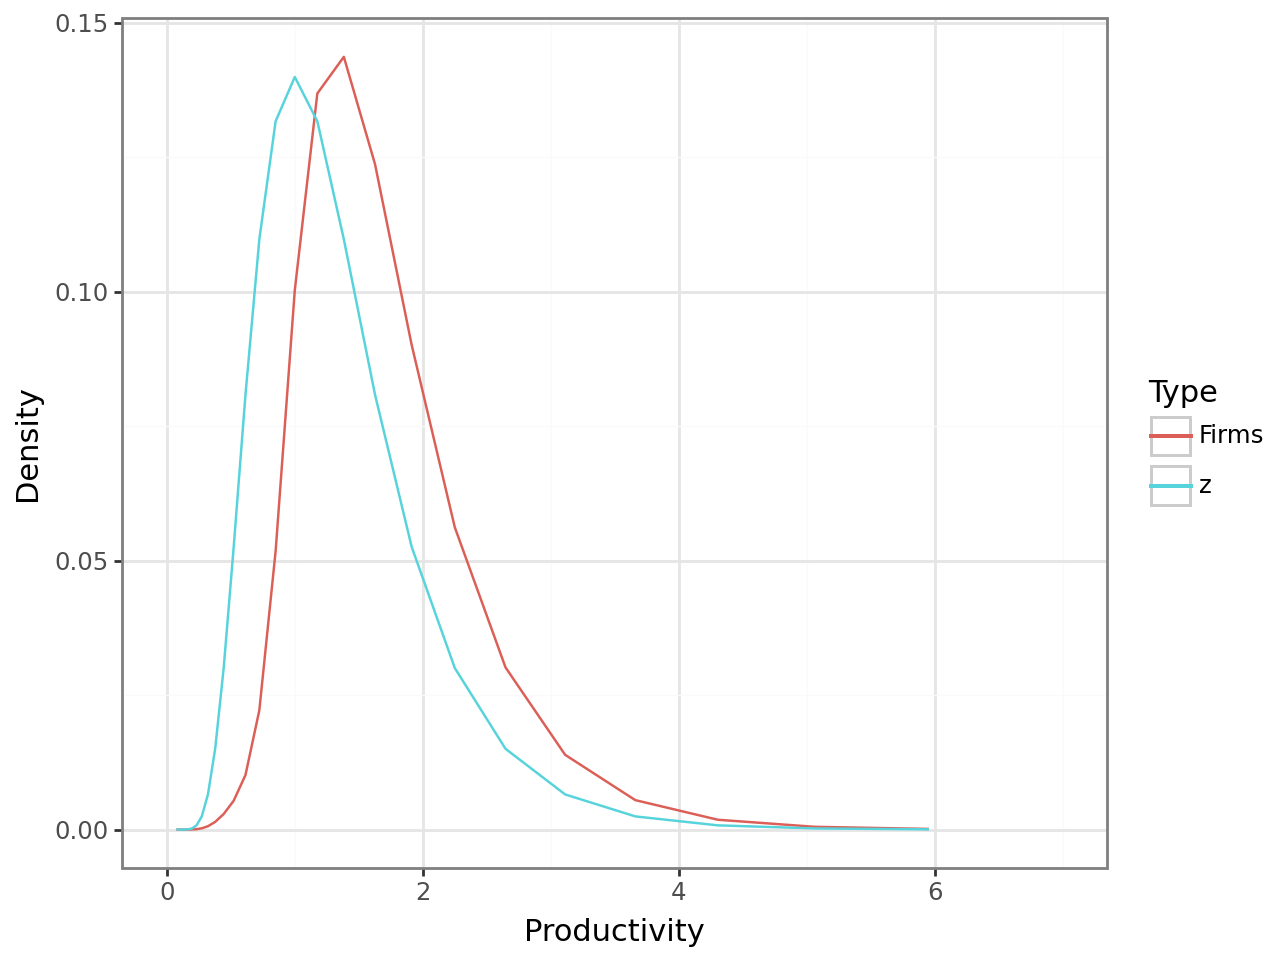

In [303]:
gdf_dist = pl.DataFrame({
    'Productivity': z_grid,
    'Firms': result_dist[1],
    'z': p_ss
}).unpivot(
    index = 'Productivity', on = ['Firms', 'z'],
    variable_name = 'Type', value_name = 'Density'
)

(
    ggplot(gdf_dist, aes('Productivity', 'Density', color = 'Type'))
    + gg.geom_line()
    + gg.xlim(0, 7)
)

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


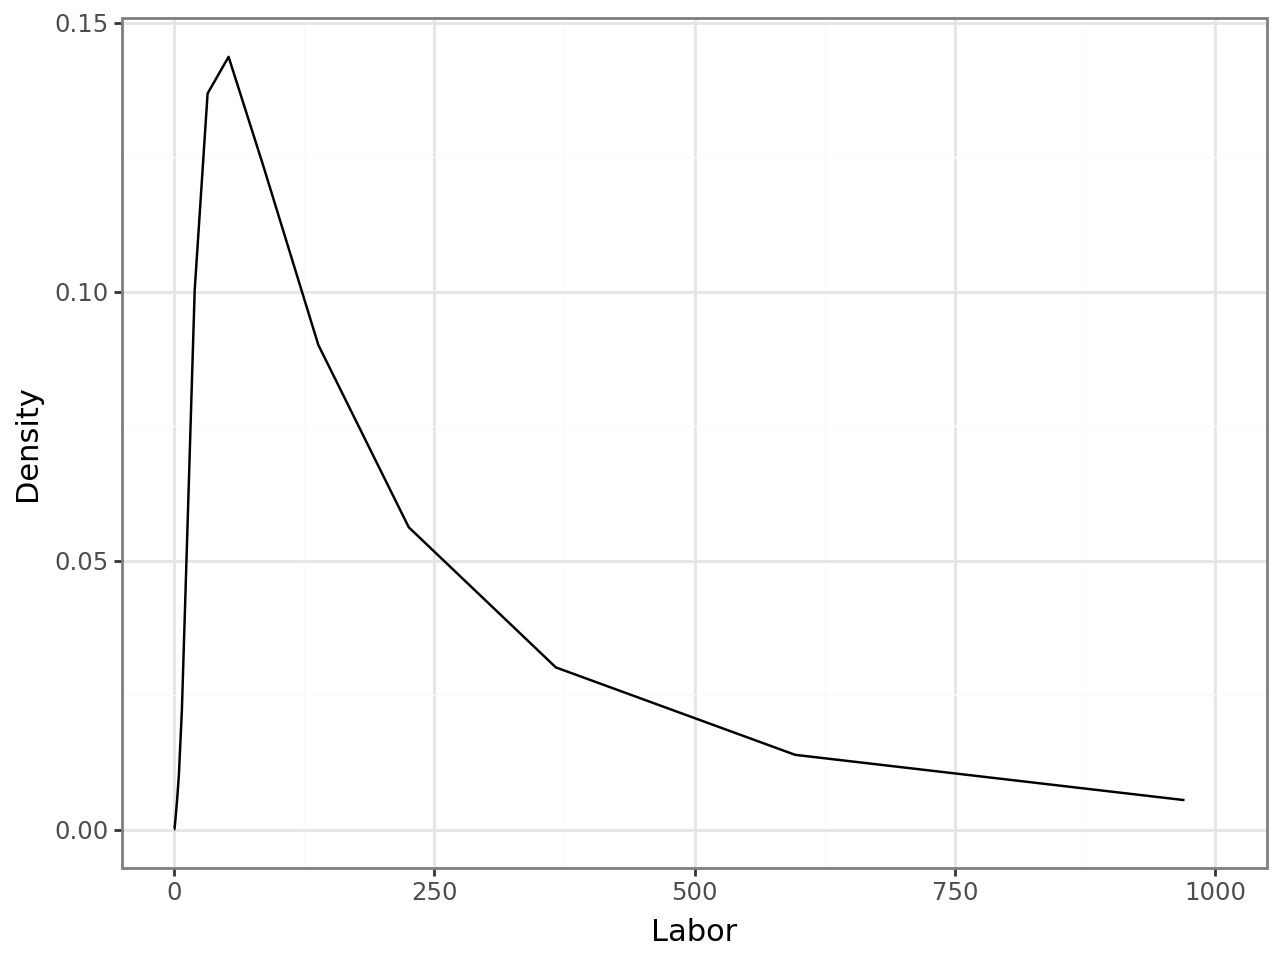

In [304]:
gdf_dist2 = pl.DataFrame({
    'Density': result_dist[1],
    'Labor': labor
})

(
    ggplot(gdf_dist2, aes('Labor', 'Density'))
    + gg.geom_line()
    + gg.xlim(0, 1000)
)

The (base) demand has increased, which means that more firms will be able to enter the market. Indeed, that's what we see, as the equilibrium entrants grows from $0.079$ to $0.095$. But, as this was a parallel change, the price and productivity level is unchanged.

We can see that a mass of firms leaves the tails and gets more concentrated at the median values, as we have more players in the market. The employment distribution is also more concentrated, with a peak at $0.15$ from $0.125$.

### 1.d)

Lets add the firing cost to the system. We need to include changes in labor in the VF. The firing cost depends on the transition of labor, so we create a `n_grid_z` x `n_grid_n` matrix to store the transitions, and multiply them by $tau$ if they are greater than zero (and nullify them otherwise):

In [305]:
tau = 0.1

def get_firing_cost(labor):
    fcost = labor.reshape(-1, 1) - labor
    return np.where(fcost > 0, tau * fcost, 0)

In this way I modelled the price, an example of a 'firing cost matrix' can be seen below.

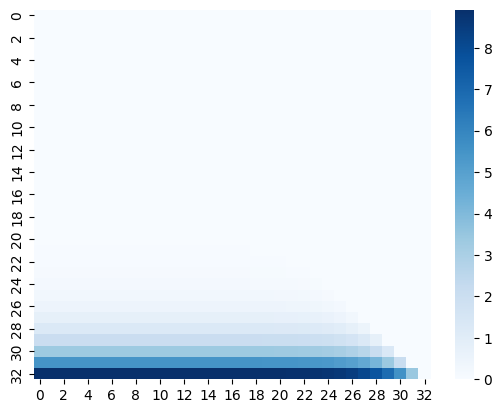

In [306]:
fcost = get_firing_cost(get_firm_choice(0.5)[0])
heatmap(fcost, annot = False, cmap = "Blues")
show()

Then, we include that cost in the VF:

In [307]:
def vif_incumbent(price, n_iter = 1000):
    v = np.zeros(n_grid_z)
    v_next = np.zeros_like(v)

    labor, profit = get_firm_choice(price)
    fcost = tau * np.sum(p @ get_firing_cost(labor), axis = 0)

    for iter in range(n_iter):
        vf_next = profit + beta * np.maximum(np.dot(p, v) - fcost, 0)
        if np.max(np.abs(vf_next - v)) < tol: break
        v = np.copy(vf_next)

    return v

Now, we can run the same algorithm as before, but with the new firing cost.

In [308]:
result_price = bisec_price()
result_dist = bisec_distribution(d)
labor, profit = get_firm_choice(result_price[0])
index = get_entrant_index(result_price[1])

f'Equilibrium price: {result_price[0]:.3f} -- \
Equilibrium entrants: {result_dist[0]:.3f} -- \
Productivity to leave: {z_grid[index]:.3f}'

'Equilibrium price: 5.676 -- Equilibrium entrants: 0.020 -- Productivity to leave: 0.850'

The expected effect is hard to predict, such that a more comprehensive analysis would be better. We can analyze the results for several values of $\tau$:

In [309]:
results_tau = []

for tau in np.linspace(0, 0.75, 50):
    result_price = bisec_price()
    result_dist = bisec_distribution(d = 100)
    labor, profit = get_firm_choice(result_price[0])
    index = get_entrant_index(result_price[1])

    results_tau.append((tau, result_price[0], result_dist[0], z_grid[index]))

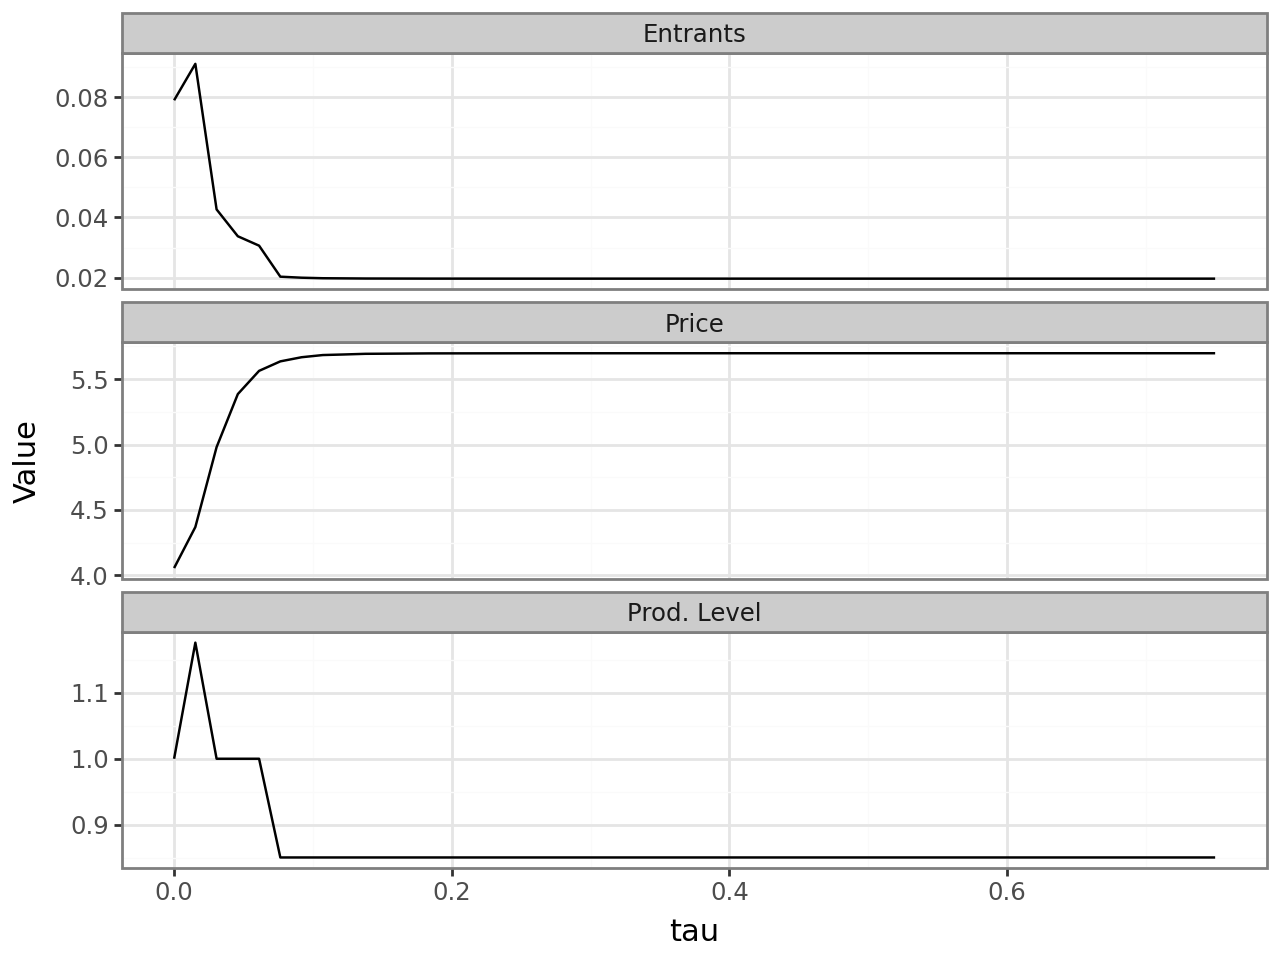

In [310]:
results_tau = pl.DataFrame(list(zip(*results_tau)))
results_tau.columns = ['tau', 'Price', 'Entrants', 'Prod. Level']

gdf_tau = results_tau.unpivot(
        index = 'tau', on = ['Price', 'Entrants', 'Prod. Level'],
        variable_name = 'Variable', value_name = 'Value'
    )

(
    ggplot(gdf_tau, aes('tau', 'Value'))
    + gg.geom_line()
    + gg.facet_wrap('Variable', ncol = 1, scales = 'free_y')
)

The price has a more simple trend of always increasing with $\tau$, as firms need to stay profitable. This poses conflicting effects on the entrants, as the demand decreases with the price.

At the same time the new cost further separates the firms at first, raising the minimal productivity level. But, as the cost increases, the incumbents get less ability to adjust, and the base productivity level decreases.

The effect that is stronger on the entrants seems to be similar as the production level one, where we have more firms entering at first, as the incumbents loose market power; but as the cost increases, entering the market turn less attractive and we have less entrants.

There are more effects at stake here, and other interpretations could be made.

## Appendix

### Tauchen Method

Here, we can see the results from the Tauchen method, referred to in question 1.a).

In [311]:
# Main parameters:
delta = 0.08
beta = 0.96
alpha = 0.4
phi = 0
rho = 0.98

# Variability parameter:
sigma = 2
sigma_z = np.sqrt(0.621)
sigma_e = np.sqrt((sigma_z ** 2) * (1 - rho ** 2))

# Iteration utilities:
tol = 1e-6
n_iter = 1000

In [312]:
n_grid_z = 7
n_periods = 10000

result_approx = quant.tauchen(n_grid_z, rho, mu = 0, sigma = sigma_e)

p = result_approx.P
z_grid_log = result_approx.state_values
z_grid = np.exp(z_grid_log)

In [313]:
z_grid.round(3)

array([ 0.094,  0.207,  0.455,  1.   ,  2.199,  4.836, 10.635])

C:\Users\ricar\AppData\Local\Temp\ipykernel_20108\234932027.py:1: RuntimeWarning: divide by zero encountered in log


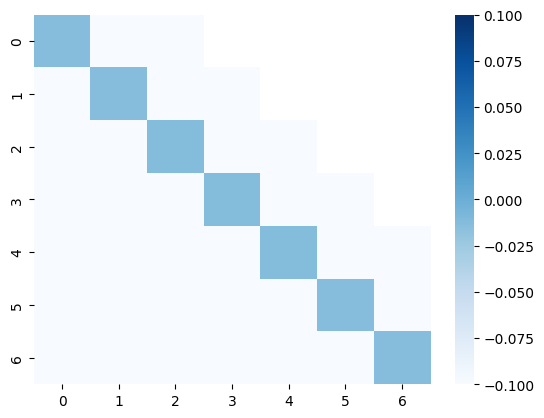

In [314]:
heatmap(np.log(p), annot=False, cmap="Blues")
show()

We can see the bigger range and the more diagonalized matrix, which is not ideal.